# Atividade 3

Problema:

$$
\left\{
    \begin{array}{ll}
        - \Delta u(x,y) = f(x,y) \;, \Omega = [0,1]\times[0,1] \\
        u(x,y) = g(x,y), \partial \Omega
    \end{array}
\right.
$$

Objetivo: Solucionar a EDP acima com métodos iterativos de Jacobi, Gauss-Seidel e SOR, analisando condições de convergência dos métodos iterativos, assim como estabilidade, consistência e convergência da discretização.


## Discretização

Domínio contínuo amostrado em $N+1$ pontos, $h = 1/N$

$$(x_m, y_n) = (mh, nh)$$

- Problema discreto:
  $$- \Delta _h U = f_h \;, U \in \mathbb{R}^{(N+1)^2}$$

- $R_h$: restrição do domínio contínuo para domínio discreto

$$R_hu = u(x_m, y_n)$$

- Laplaciano discreto de 5 pontos:

$$\Delta _h U = \frac{1}{h^2} (-4U_{mn} + U_{m-1,n} + U_{m+1,n} + U_{m,n -1} + U_{m,n+1})$$

<!-- $$
\begin{cases}
  - \Delta _h U = f_h\\
  \\

\end{cases}
$$ -->


## Consistência

Erro de Truncamento:

$$\Tau _h= R_h\Delta u - \Delta _h R_hu$$

Para o laplaciano de 5 pontos:

$$R_h\Delta u = \partial_{xx}u(x_m, y_n) + \partial_{yy}u(x_m, y_n)$$

$$\Delta _h R_hu= \Delta _h u(x_m,y_n) = \frac{1}{h^2} (-4u(x_m,y_n) + u(x_m-h,y_n) + u(x_m+h,y_n) + u(x_m,y_n -h) + u(x_m,y_n+h))$$

Expandindo nas séries de Taylor:

$$
\begin{align*}
    u(x_{m\pm 1}, y_n) &= u(x_m, y_n) \pm h \frac{\partial u}{\partial x} + \frac{h^2}{2} \frac{\partial^2 u}{\partial x^2} \pm \frac{h^3}{6} \frac{\partial^3 u}{\partial x^3} + \frac{h^4}{24} \frac{\partial^4 u}{\partial x^4} + \mathcal{O}(h^5), \\
    u(x_m, y_{n\pm 1}) &= u(x_m, y_n) \pm h \frac{\partial u}{\partial y} + \frac{h^2}{2} \frac{\partial^2 u}{\partial y^2} \pm \frac{h^3}{6} \frac{\partial^3 u}{\partial y^3} + \frac{h^4}{24} \frac{\partial^4 u}{\partial y^4} + \mathcal{O}(h^5).
\end{align*}
$$

Substituindo na expressão para $\Delta _h R_hu$,

$$
\Delta _h R_hu = \partial _{xx} u (x_m, y_n) + \partial _{yy} u(x_m, y_n) + \mathcal{O}(h^2)
$$

Então o erro de truncamento é

$$\Tau _h= R_h\Delta u - \Delta _h R_hu = \mathcal{O}(h^2)$$

Portanto, a discretização do laplaciano de 5 pontos é consistente de segunda ordem.


## Estabilidade

Dizemos que $\Delta _h$ é estável se $\exists C \in \mathbb{R}$ tal que

$$||\Delta _h ^{-1}|| \le C$$

Para condições de fronteira de Dirichlet, a matriz $\Delta _h$ tem autovalores da forma

$$
\lambda = \frac{4}{h^2}(\sin^2\frac{p\theta}{2} + \sin^2\frac{q\theta}{2}) \\
\theta = \frac{\pi}{N} \\
p, q = 1,\ldots,N-1
$$

Então, para obter $||\Delta _h ^{-1}||$, escolhemos o menor autovalor de $\Delta _h$, com $p = q = 1$:

$$\lambda_{\text{min}} = \frac{4}{h^2}(\sin^2\frac{\theta}{2} + \sin^2\frac{\theta}{2}) = \frac{8}{h^2}\sin^2\frac{\theta}{2}$$

Como os autovalores de $\Delta _h ^{-1}$ são os inversos dos autovalores de $\Delta _h$, o máximo autovalor de $\Delta _h ^{-1}$ é

$$||\Delta _h ^{-1}|| = \frac{1}{\frac{8}{h^2}\sin^2\frac{\theta}{2}} < C, \text{para } 0<h<h_0$$

Logo, $\Delta _h$ é estável.


## Implementação


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


def exact_solution_f(x, y):
    # u(x, y) = \sin(\pi x) \sin(\pi y)
    # f(x, y) = 2\pi^2 \sin(\pi x) \sin(\pi y)
    return 2 * np.pi**2 * np.sin(np.pi * x) * np.sin(np.pi * y)


def exact_solution_u(x, y):
    # u(x, y) = \sin(\pi x) \sin(\pi y)
    # f(x, y) = 2\pi^2 \sin(\pi x) \sin(\pi y)
    return np.sin(np.pi * x) * np.sin(np.pi * y)


def lam_jacobi(h, p, q):
    """Eigenvalues for Jacobi iteration matrix

    :param h: spatial discretization step
    :type h: float
    :param p: eigenvalue index
    :type p: int
    :param q: eigenvalue index
    :type q: int
    :return: eigenvalue of Jacobi iteration matrix
    :rtype: float
    """
    return 1 / 2 * (np.cos(p * np.pi * h) + np.cos(q * np.pi * h))


def lex_to_seq(m, n, row_size):
    return m + n * row_size


def L2_norm(v: np.ndarray, delta_x: float):
    """Calculate L2 (h) norm of vector v

    :param v: vector to calculate the norm of
    :type v: np.ndarray
    :param delta_x: distance between each point of vector
    :type delta_x: float
    :return: norm
    :rtype: float
    """
    return np.sqrt(delta_x * np.sum(v**2))


def jacobi_step(
    U_curr,
    U_next,
    f_h,
    N,
):
    h = 1 / N

    # Compute the indices for inner points (excluding boundaries)
    inner_indices = (
        np.arange((N + 1) * (N + 1)).reshape(N + 1, N + 1)[1:N, 1:N].flatten()
    )

    # Compute neighbors in the flattened array
    left_neighbors = inner_indices - 1
    right_neighbors = inner_indices + 1
    top_neighbors = inner_indices + (N + 1)
    bottom_neighbors = inner_indices - (N + 1)

    U_next[inner_indices] = (
        1
        / 4
        * (
            h**2 * f_h[inner_indices]
            + U_curr[left_neighbors]
            + U_curr[right_neighbors]
            + U_curr[top_neighbors]
            + U_curr[bottom_neighbors]
        )
    )

    rows, cols = np.indices((N + 1, N + 1))
    rows = rows.flatten()
    cols = cols.flatten()
    U_next = np.where(
        (rows == 0) | (rows == N) | (cols == 0) | (cols == N),
        0,
        U_next,
    )

    return U_next


def gs_step(U_curr, U_next, f, N):
    h = 1 / N

    for n in range(1, N):
        for m in range(1, N):
            i = lex_to_seq(m, n, N + 1)
            U_next[i] = (
                1
                / 4
                * (
                    h**2 * f[i]
                    + U_next[i - 1]
                    + U_next[i + 1]
                    + U_next[i + N + 1]
                    + U_next[i - N - 1]
                )
            )
    return U_next


def sor_step_fabricator(omega):
    def sor_step(U_curr, U_next, f, N):
        U_prev = np.copy(U_curr)
        U_next = gs_step(U_curr, U_next, f, N)
        U_next = omega * U_next + (1 - omega) * U_prev
        return U_next

    return sor_step


def general_solver(U_curr, U_next, U_exact, f_h, N, step, max_k, epsilon):
    U_curr = np.copy(U_curr)
    U_next = np.copy(U_next)

    for k in range(max_k):
        U_next = step(U_curr, U_next, f_h, N)
        U_curr = np.copy(U_next)

        error = L2_norm(U_exact - U_curr, 1 / N)
        if error < epsilon:
            break

    return U_curr, error, k


def jacobi_solver(U_curr, U_next, U_exact, f_h, N, max_k=1000, epsilon=0.05):
    return general_solver(U_curr, U_next, U_exact, f_h, N, jacobi_step, max_k, epsilon)


def gs_solver(U_curr, U_exact, f_h, N, max_k=1000, epsilon=0.05):
    U_next = np.copy(U_curr)
    return general_solver(U_curr, U_next, U_exact, f_h, N, gs_step, max_k, epsilon)


def sor_solver(omega, U_curr, U_exact, f_h, N, max_k=1000, epsilon=0.05):
    U_next = np.copy(U_curr)
    return general_solver(
        U_curr, U_next, U_exact, f_h, N, sor_step_fabricator(omega), max_k, epsilon
    )


def create_table(list_of_arrays, column_names):
    df = pd.DataFrame(
        np.round(
            np.array(list_of_arrays).T,
            decimals=10,
        ),
        columns=column_names,
    )
    return df


def create_ratio_column(
    df, ratio_column_name="Error ratio", raw_column_name="Error [L2 norm]"
):
    df[ratio_column_name] = df[raw_column_name] / df[raw_column_name].shift(1)
    df[ratio_column_name] = df[ratio_column_name].fillna("")

    return df

## Análise da convergência - discretização

A convergência do método discreto para solução da EDP é medida comparando a solução discreta com a solução analítica. Para essa comparação, foi utilizada a solução analítica

$$u(x, y) = \sin(\pi x) \sin(\pi y)$$

Com $f(x, y) = 2\pi^2 \sin(\pi x) \sin(\pi y)$ e condições de fronteira de Dirichlet nulo.

As soluções numéricas da EDP foram obtidas utilizando os métodos de Jacobi, Gauss-Seidel e SOR, com um número fixo de iterações. Dessa forma, é possível observar a mudança no valor do erro conforme $h$ diminui.


In [2]:
def run_convergence(N=25, max_k=4001, epsilon=0.1, omega_sor=1.5):

    # Generate grid points
    x = np.linspace(0, 1, N + 1)  # x-coordinates
    y = np.linspace(0, 1, N + 1)  # y-coordinates
    X, Y = np.meshgrid(x, y)  # Create a grid of points
    # Compute f_h by evaluating f(x, y) at each grid point
    f_h = exact_solution_f(X, Y).flatten()

    U_curr = np.zeros((N + 1) ** 2)  # mudar para zeros
    U_next = np.zeros((N + 1) ** 2)  # mudar para zeros

    # Apply dirichlet boundary condition
    g = 0
    rows, cols = np.indices((N + 1, N + 1))
    rows = rows.flatten()
    cols = cols.flatten()
    U_curr = np.where(
        (rows == 0) | (rows == N) | (cols == 0) | (cols == N),
        g,
        U_curr,
    )

    U_exact = exact_solution_u(X.flatten(), Y.flatten())

    max_k = max_k  # large max_k -> run until error < epsilon
    epsilon = epsilon  # epsilon = 0 -> run max_k iterations
    omega_sor = omega_sor
    U_sor, error_sor, k_sor = sor_solver(
        omega_sor, U_curr, U_exact, f_h, N, max_k, epsilon
    )
    U_gs, error_gs, k_gs = gs_solver(U_curr, U_exact, f_h, N, max_k, epsilon)
    U_jacobi, error_jacobi, k_jacobi = jacobi_solver(
        U_curr, U_next, U_exact, f_h, N, max_k, epsilon
    )

    return (
        U_jacobi,
        error_jacobi,
        k_jacobi,
        U_gs,
        error_gs,
        k_gs,
        U_sor,
        error_sor,
        k_sor,
    )

> Observação sobre tempo de execução no Google Collab: Esse notebook foi executado no meu laptop pessoal, com células levando no máximo 2 minutos para finalizarem a execução. Ao executá-lo no Google Collab, as execuções de algumas células passaram de 5 minutos. Caso seja necessário reduzir o tempo de execução, basta remover os últimos casos de execução. No exemplo abaixo, isso corresponderia a remover alguns dos valores do vetor `Ns`:
>
> ```
> Ns = [4, 8, 16, 32, 64, 128] -> Ns = [4, 8, 16, 32, 64]
> ```


In [3]:
errors_jacobi = []
errors_gs = []
errors_sor = []
hs = []
lams_jacobi = []
lams_gs = []
ks_jacobi = []
ks_gs = []
ks_sor = []

Ns = [4, 8, 16, 32, 64, 128]

for N in Ns:
    U_jacobi, error_jacobi, k_jacobi, U_gs, error_gs, k_gs, U_sor, error_sor, k_sor = (
        run_convergence(N=N, max_k=4001, epsilon=0, omega_sor=1.5)
    )
    errors_jacobi.append(error_jacobi)
    errors_gs.append(error_gs)
    errors_sor.append(error_sor)
    hs.append(1 / N)
    lams_jacobi.append(lam_jacobi(1 / N, 1, 1))
    lams_gs.append((lam_jacobi(1 / N, 1, 1)) ** 2)
    ks_jacobi.append(k_jacobi)
    ks_gs.append(k_gs)
    ks_sor.append(k_sor)

df = create_table(
    [
        hs,
        ks_jacobi,
        lams_jacobi,
        lams_gs,
        errors_jacobi,
        errors_gs,
        errors_sor,
    ],
    [
        "h",
        "k",
        "lam [J]",
        "lam [GS]",
        "E [J]",
        "E [GS]",
        "E [SOR]",
    ],
)

df = create_ratio_column(df, "E ratio [J]", "E [J]")
df = create_ratio_column(df, "E ratio [GS]", "E [GS]")
df = create_ratio_column(df, "E ratio [SOR]", "E [SOR]")
print(df)

          h       k   lam [J]  lam [GS]     E [J]    E [GS]   E [SOR]  \
0  0.250000  4000.0  0.707107  0.500000  0.053029  0.053029  0.053029   
1  0.125000  4000.0  0.923880  0.853553  0.018315  0.018315  0.018315   
2  0.062500  4000.0  0.980785  0.961940  0.006438  0.006438  0.006438   
3  0.031250  4000.0  0.995185  0.990393  0.002273  0.002273  0.002273   
4  0.015625  4000.0  0.998795  0.997592  0.031397  0.000544  0.000801   
5  0.007812  4000.0  0.999699  0.999398  1.694763  0.507748  0.151856   

  E ratio [J] E ratio [GS] E ratio [SOR]  
0                                         
1    0.345377     0.345377      0.345377  
2    0.351509     0.351509      0.351509  
3     0.35304     0.353042      0.353042  
4   13.813803       0.2393      0.352515  
5    53.97902   933.538058    189.531341  


Nos testes acima, é possível observar que conforme h diminui, o erro $||R_hu - U||$ também diminui, com ordem aproximadamente 2, conforme esperado, já que a ordem de consistência do operador laplaciano é 2, e temos que $||R_hu - U|| \le C||\Tau|| = \mathcal{O}(h^2)$, portanto $||R_hu - U|| = \mathcal{O}(h^2)$.

Porém, conforme h fica muito pequeno, o erro volta a aumentar. Isso ocorre devido ao fato de que conforme h fica menor, a taxa convergência dos métodos iterativos fica cada vez menor (veja na tabela que $\lambda _{J}$ e $\lambda _{GS}$ tem valores perto de $0.999$ na última linha, sendo esses os raios espectrais das matrizes de iteração de Jacobi e Gauss-Seidel), fazendo com que a aproximação da solução do sistema linear tenha erro alto, pois o número máximo de iterações está fixo nesse experimento.

> Obs: nas tabelas, as colunas "E ratio" são obtidas dividindo os valores das colunas de erro pelo valor da linha de cima, obtendo assim a razão entre o erro atual e o anterior

Abaixo, foram feitos os gráficos das soluções de cada método e da solução analítica para inspeção visual:


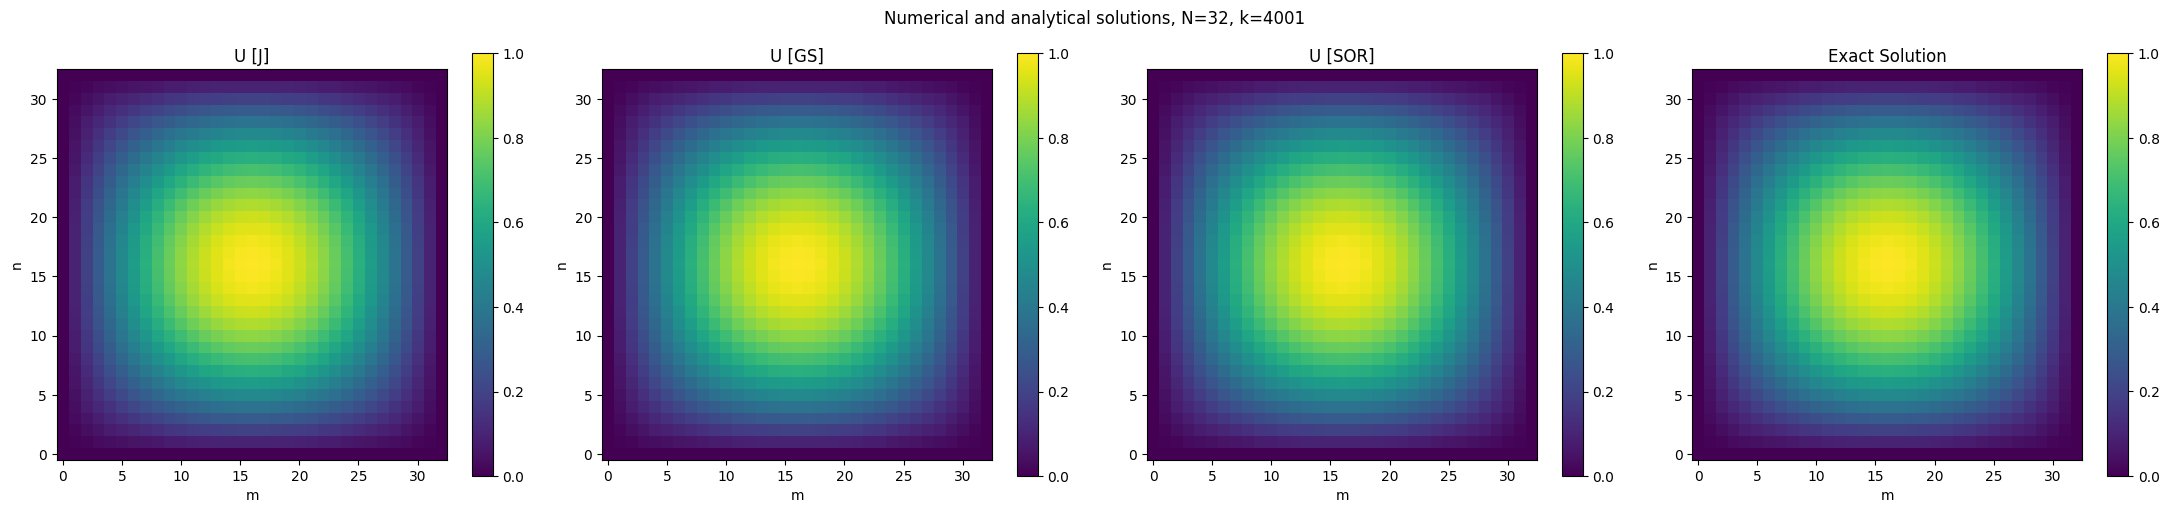

In [4]:
N = 32
max_k = 4001
U_jacobi, error_jacobi, k_jacobi, U_gs, error_gs, k_gs, U_sor, error_sor, k_sor = (
    run_convergence(N=N, max_k=max_k, epsilon=0, omega_sor=1.5)
)


# Plotting
def plot_results(
    N,
    max_k,
    U_jacobi,
    U_gs,
    U_sor,
):
    # Set scale
    # vmin = 0
    # vmax = 1
    # Plot the arrays
    fig, axes = plt.subplots(1, 4, figsize=(22, 5))
    fig.suptitle(f"Numerical and analytical solutions, N={N}, k={max_k}")
    axes = axes.flatten()
    # Plot U
    im1 = axes[0].imshow(
        U_jacobi.reshape((N + 1, N + 1)),
        origin="lower",
        cmap="viridis",
        # vmin=vmin,
        # vmax=vmax,
    )
    axes[0].set_title("U [J]")
    axes[0].set_xlabel("m")
    axes[0].set_ylabel("n")
    fig.colorbar(im1, ax=axes[0])
    # Plot U
    im2 = axes[1].imshow(
        U_gs.reshape(N + 1, N + 1),
        origin="lower",
        cmap="viridis",
        # vmin=vmin,
        # vmax=vmax,
    )
    axes[1].set_title("U [GS]")
    axes[1].set_xlabel("m")
    axes[1].set_ylabel("n")
    fig.colorbar(im2, ax=axes[1])
    # Plot U
    im1 = axes[2].imshow(
        U_sor.reshape(N + 1, N + 1),
        origin="lower",
        cmap="viridis",
        # vmin=vmin,
        # vmax=vmax,
    )
    axes[2].set_title("U [SOR]")
    axes[2].set_xlabel("m")
    axes[2].set_ylabel("n")
    fig.colorbar(im1, ax=axes[2])

    # Plot exact solution
    # Generate grid points
    x = np.linspace(0, 1, N + 1)  # x-coordinates
    y = np.linspace(0, 1, N + 1)  # y-coordinates
    X, Y = np.meshgrid(x, y)  # Create a grid of points
    im4 = axes[3].imshow(
        exact_solution_u(X, Y),
        origin="lower",
        cmap="viridis",
        # vmin=vmin,
        # vmax=vmax,
    )
    axes[3].set_title("Exact Solution")
    axes[3].set_xlabel("m")
    axes[3].set_ylabel("n")
    fig.colorbar(im4, ax=axes[3])
    plt.tight_layout()
    plt.show()


plot_results(N, max_k, U_jacobi, U_gs, U_sor)

## Análise da convergência - Métodos Iterativos

A convergência dos métodos iterativos Jacobi, Gauss-Seidel e SOR irá depender da norma da matriz de iteração, que por sua vez é igual ao módulo do maior autovalor dessa matriz (raio espectral).

Podemos encontrar os autovalores da matriz de iteração do método de Jacobi utilizando os autovalores conhecidos da matriz do laplaciano discreto, obtendo

$$\lambda _J = 1 - \frac{1}{4} h^2 \lambda $$

$$\lambda _J = \frac{1}{2}(\cos\left( p \pi h \right) + \cos\left( 1 \pi h \right))$$

Podemos obter os autovalores da matriz de iteração de Gauss-Seidel em função de $\lambda _J$:

$$\lambda _{GS} = \lambda _J ^2$$

Para o método SOR, se a matriz do sistema linear for S.P.D., o método converge se $0<\omega<2$ para qualquer chute inicial.

Para verificar a convergência dos métodos iterativos, serão feitos experimentos fixando o valor de $h$, e variando o número de iterações realizadas pelos métodos iterativos


In [5]:
errors_jacobi = []
errors_gs = []
errors_sor = []
ks = []

max_ks = [2, 3, 4, 11, 401, 1001, 4001]
N = 20
for max_k in max_ks:
    U_jacobi, error_jacobi, k_jacobi, U_gs, error_gs, k_gs, U_sor, error_sor, k_sor = (
        run_convergence(N=N, max_k=max_k, epsilon=0, omega_sor=1.66)
    )
    errors_jacobi.append(error_jacobi)
    errors_gs.append(error_gs)
    errors_sor.append(error_sor)
    ks.append(k_jacobi)

df = create_table(
    [
        ks,
        errors_jacobi,
        errors_gs,
        errors_sor,
    ],
    [
        "k",
        "E [J]",
        "E [GS]",
        "E [SOR]",
    ],
)
df = create_ratio_column(df, "E ratio [J]", "E [J]")
df = create_ratio_column(df, "E ratio [GS]", "E [GS]")
df = create_ratio_column(df, "E ratio [SOR]", "E [SOR]")
print(df)

h = 1 / N
lam_gs = (lam_jacobi(1 / N, 1, 1)) ** 2
print(
    f"h: {h}\nlam [J]: {float(lam_jacobi(1 / N, 1, 1)):.6f}\nlam [GS]: {float(lam_gs):.6f}"
)

        k     E [J]    E [GS]   E [SOR] E ratio [J] E ratio [GS] E ratio [SOR]
0     1.0  2.181235  2.129422  2.060426                                       
1     2.0  2.154324  2.077966  1.977707    0.987662     0.975835      0.959854
2     3.0  2.127744  2.027723  1.898240    0.987662     0.975821      0.959819
3    10.0  1.950624  1.707863  1.423344    0.916757     0.842257      0.749823
4   400.0  0.010991  0.004494  0.004603    0.005635     0.002631      0.003234
5  1000.0  0.004594  0.004603  0.004603    0.417995     1.024398      1.000029
6  4000.0  0.004603  0.004603  0.004603    1.002008          1.0           1.0
h: 0.05
lam [J]: 0.987688
lam [GS]: 0.975528


É possível ver pelo experimento acima que o erro cai de forma proporcional à taxa de convergência esperada para os métodos, até chegar em um erro mínimo, a partir do qual o erro dominante é aquele devido à discretização do laplaciano. A partir desse ponto, o erro não cai mais, pois o valor de $h$ está fixo.


### Jacobi x Gauss-Seidel

Como o raio espectral da matriz de iteração do método de Gauss-Seidel é o quadrado do raio espectral da matriz de iteração do método de Jacobi, é esperado que o método de Jacobi precise o dobro de iterações que o método de Gauss-Seidel para atingir um mesmo valor de erro da aproximação do sistema linear.

Demonstração:

Queremos $k$ tal que $||e^k|| < \epsilon$

$$||e^k|| \le ||G||^k \,||e^0||$$
$$\log||e^k|| \le \log||G||^k \,||e^0||$$
$$\log||e^k|| \le k\log||G|| + C$$
$$k \ge \frac{\log||e^k||}{\log||G||}$$
$$k_{GS} \ge \frac{\log||e^k||}{\log(\lambda_{GS})} = \frac{\log||e^k||}{\log(\lambda_{J}^2)} = \frac{\log||e^k||}{2\log(\lambda_{J})}$$
$$k_{J} \ge \frac{\log||e^k||}{\log(\lambda_{J})}$$

$$k_{GS} \propto \frac{1}{2} k_J$$

Apesar disso, hoje em dia, graças aos avanços na área de computação paralela e distribuída, o método de Jacobi pode ser muito mais rápido que o de Gauss-Seidel por permitir paralelismo.

O experimento abaixo mostra essa relação entre $k_{GS}$ e $k_J$.


In [6]:
errors_jacobi = []
errors_gs = []
ks_gs = []
ks_jacobi = []

max_k = 10000  # Large max_k -> run until error < epsilon
epsilons = [1 / 2, 1 / 4, 1 / 8, 1 / 16, 1 / 32, 1 / 64]
N = 20
for epsilon in epsilons:
    U_jacobi, error_jacobi, k_jacobi, U_gs, error_gs, k_gs, U_sor, error_sor, k_sor = (
        run_convergence(N=N, max_k=max_k, epsilon=epsilon, omega_sor=1.69)
    )
    errors_jacobi.append(error_jacobi)
    errors_gs.append(error_gs)
    ks_jacobi.append(k_jacobi)
    ks_gs.append(k_gs)

df = create_table(
    [
        ks_jacobi,
        ks_gs,
        errors_jacobi,
        errors_gs,
    ],
    [
        "k [J]",
        "k [GS]",
        "E [J]",
        "E [GS]",
    ],
)
# df = create_ratio_column(df, "E ratio [J]", "E [J]")
# df = create_ratio_column(df, "E ratio [GS]", "E [GS]")
print(df)

h = 1 / N
lam_gs = (lam_jacobi(1 / N, 1, 1)) ** 2
print(
    f"h: {h}\nlam [J]: {float(lam_jacobi(1 / N, 1, 1)):.6f}\nlam [GS]: {float(lam_gs):.6f}"
)

   k [J]  k [GS]     E [J]    E [GS]
0  120.0    60.0  0.495880  0.495059
1  175.0    88.0  0.248609  0.245321
2  230.0   115.0  0.123506  0.123466
3  283.0   142.0  0.061838  0.061012
4  333.0   167.0  0.031160  0.030722
5  379.0   190.0  0.015624  0.015383
h: 0.05
lam [J]: 0.987688
lam [GS]: 0.975528


Podemos observar na tabela acima que, como esperado, o método de Jacobi precisa do dobro de iterações que o método de Gauss-Seidel para obter o mesmo erro.


### Gauss-Seidel x SOR

O método SOR funciona como o método de Gauss-Seidel com uma relaxação maior. Essa relaxação extra pode melhorar ou piorar a convergência do método, dependendo o fator de relaxação $\omega$. O experimento abaixo foi feito para comparar o desempenho dos métodos de Gauss-Seidel e SOR para diferentes valores de $\omega$.


In [7]:
errors_sor = []
errors_gs = []
ks_gs = []
ks_sor = []

max_k = 1000
epsilon = 0.1
omegas_sor = np.linspace(
    0.2, 1.8, 17
)  # Values close to 0 or 2 cause the convergence rate to be very close to 1 (very slow)
N = 40
for omega_sor in omegas_sor:
    U_jacobi, error_jacobi, k_jacobi, U_gs, error_gs, k_gs, U_sor, error_sor, k_sor = (
        run_convergence(N=N, max_k=max_k, epsilon=epsilon, omega_sor=omega_sor)
    )
    errors_sor.append(error_sor)
    errors_gs.append(error_gs)
    ks_sor.append(k_sor)
    ks_gs.append(k_gs)

df = create_table(
    [
        omegas_sor,
        ks_sor,
        ks_gs,
        errors_sor,
        errors_gs,
    ],
    [
        "omega",
        "k [SOR]",
        "k [GS]",
        "E [SOR]",
        "E [GS]",
    ],
)
df = create_ratio_column(df, "E ratio [GS]", "E [GS]")
df = create_ratio_column(df, "E ratio [SOR]", "E [SOR]")
print(df)

h = 1 / N
lam_gs = (lam_jacobi(1 / N, 1, 1)) ** 2
print(
    f"h: {h}\nlam [J]: {float(lam_jacobi(1 / N, 1, 1)):.6f}\nlam [GS]: {float(lam_gs):.6f}"
)

    omega  k [SOR]  k [GS]       E [SOR]    E [GS] E ratio [GS]  \
0     0.2    999.0   557.0  9.236875e-01  0.099566                
1     0.3    999.0   557.0  4.980327e-01  0.099566          1.0   
2     0.4    999.0   557.0  2.680298e-01  0.099566          1.0   
3     0.5    999.0   557.0  1.438351e-01  0.099566          1.0   
4     0.6    929.0   557.0  9.999747e-02  0.099566          1.0   
5     0.7    796.0   557.0  9.995216e-02  0.099566          1.0   
6     0.8    697.0   557.0  9.953160e-02  0.099566          1.0   
7     0.9    619.0   557.0  9.967370e-02  0.099566          1.0   
8     1.0    557.0   557.0  9.956583e-02  0.099566          1.0   
9     1.1    506.0   557.0  9.964547e-02  0.099566          1.0   
10    1.2    464.0   557.0  9.935017e-02  0.099566          1.0   
11    1.3    428.0   557.0  9.942957e-02  0.099566          1.0   
12    1.4    397.0   557.0  9.963419e-02  0.099566          1.0   
13    1.5    370.0   557.0  9.996490e-02  0.099566          1.

É possível ver no experimento acima que dependendo de $\omega$, o método SOR pode convergir mais rapida ou lentamente que o método de Gauss-Seidel, convergindo na mesma velocidade no caso que $\omega = 1$, quando os métodos são equivalentes.


### $\omega^*$

A partir de experimentos como o anterior, podemos obter o valor de $\omega^*$


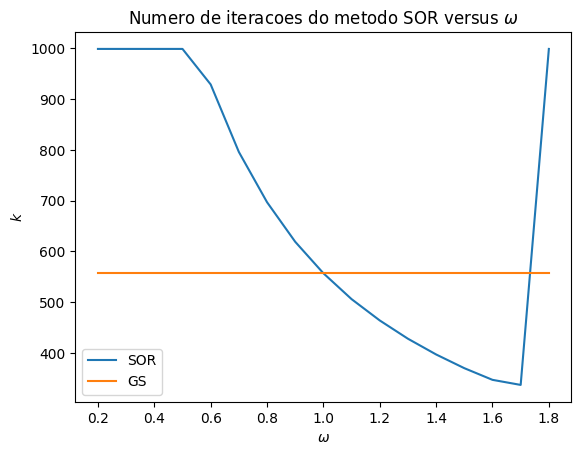

In [8]:
plt.title(r"Numero de iteracoes do metodo SOR versus $\omega$")
plt.plot(omegas_sor, ks_sor, label="SOR")
plt.plot(omegas_sor, ks_gs, label="GS")
plt.xlabel(r"$\omega$")
plt.ylabel(r"$k$")
plt.legend()
plt.show()

Aumentando a resolução em torno do ponto mínimo:


In [9]:
errors_sor = []
errors_gs = []
ks_gs = []
ks_sor = []

max_k = 1000  # Large max_k -> run until error < epsilon
epsilon = 0.1
omegas_sor = np.linspace(1.65, 1.72, 20)
N = 40
for omega_sor in omegas_sor:
    U_jacobi, error_jacobi, k_jacobi, U_gs, error_gs, k_gs, U_sor, error_sor, k_sor = (
        run_convergence(N=N, max_k=max_k, epsilon=epsilon, omega_sor=omega_sor)
    )
    errors_sor.append(error_sor)
    errors_gs.append(error_gs)
    ks_sor.append(k_sor)
    ks_gs.append(k_gs)

df = create_table(
    [
        omegas_sor,
        ks_sor,
        ks_gs,
        errors_sor,
        errors_gs,
    ],
    [
        "omega",
        "k [SOR]",
        "k [GS]",
        "E [SOR]",
        "E [GS]",
    ],
)
df = create_ratio_column(df, "E ratio [GS]", "E [GS]")
df = create_ratio_column(df, "E ratio [SOR]", "E [SOR]")
print(df)

       omega  k [SOR]  k [GS]   E [SOR]    E [GS] E ratio [GS] E ratio [SOR]
0   1.650000    337.0   557.0  0.099052  0.099566                           
1   1.653684    336.0   557.0  0.099303  0.099566          1.0      1.002531
2   1.657368    335.0   557.0  0.099559  0.099566          1.0      1.002578
3   1.661053    334.0   557.0  0.099820  0.099566          1.0      1.002624
4   1.664737    334.0   557.0  0.099044  0.099566          1.0      0.992229
5   1.668421    333.0   557.0  0.099311  0.099566          1.0      1.002694
6   1.672105    332.0   557.0  0.099583  0.099566          1.0      1.002741
7   1.675789    331.0   557.0  0.099861  0.099566          1.0      1.002787
8   1.679474    331.0   557.0  0.099092  0.099566          1.0      0.992298
9   1.683158    330.0   557.0  0.099375  0.099566          1.0      1.002857
10  1.686842    329.0   557.0  0.099665  0.099566          1.0      1.002924
11  1.690526    329.0   557.0  0.098949  0.099566          1.0      0.992813

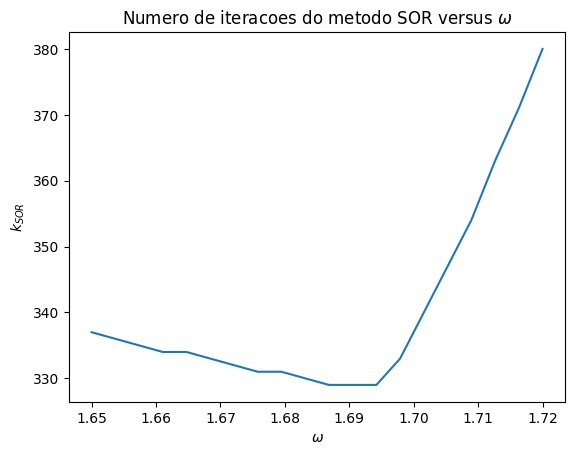

In [10]:
ks_sor = np.array(ks_sor)
plt.title(r"Numero de iteracoes do metodo SOR versus $\omega$")
plt.plot(omegas_sor, ks_sor)
plt.xlabel(r"$\omega$")
plt.ylabel(r"$k_{SOR}$")
plt.show()

Podemos ver que o método SOR atingiu o erro determinado com o menor número de iterações para esse problema nos casos que $\omega$ está em torno de 1.69


## Sensibilidade ao chute inicial

Nos experimentos abaixo, variamos o chute inicial dos métodos iterativos e observamos que o método de Jacobi não converge para a solução exata dependendo da escolha, porém os métodos de Gauss-Seidel e SOR convergem, como esperado.


In [11]:
def run_convergence_initial_guess(
    initial_guess, N=40, max_k=1001, epsilon=0.01, omega_sor=1.674
):

    # Generate grid points
    x = np.linspace(0, 1, N + 1)  # x-coordinates
    y = np.linspace(0, 1, N + 1)  # y-coordinates
    X, Y = np.meshgrid(x, y)  # Create a grid of points
    # Compute f_h by evaluating f(x, y) at each grid point
    f_h = exact_solution_f(X, Y).flatten()

    # U_curr = np.zeros((N + 1) ** 2)  # mudar para zeros
    # U_next = np.zeros((N + 1) ** 2)  # mudar para zeros
    U_curr = initial_guess  # mudar para zeros
    U_next = initial_guess  # mudar para zeros

    # Apply dirichlet boundary condition
    g = 0
    rows, cols = np.indices((N + 1, N + 1))
    rows = rows.flatten()
    cols = cols.flatten()
    U_curr = np.where(
        (rows == 0) | (rows == N) | (cols == 0) | (cols == N),
        g,
        U_curr,
    )

    U_exact = exact_solution_u(X.flatten(), Y.flatten())

    max_k = max_k  # large max_k -> run until error < epsilon
    epsilon = epsilon  # epsilon = 0 -> run max_k iterations
    omega_sor = omega_sor
    U_sor, error_sor, k_sor = sor_solver(
        omega_sor, U_curr, U_exact, f_h, N, max_k, epsilon
    )
    U_gs, error_gs, k_gs = gs_solver(U_curr, U_exact, f_h, N, max_k, epsilon)
    U_jacobi, error_jacobi, k_jacobi = jacobi_solver(
        U_curr, U_next, U_exact, f_h, N, max_k, epsilon
    )

    return (
        U_jacobi,
        error_jacobi,
        k_jacobi,
        U_gs,
        error_gs,
        k_gs,
        U_sor,
        error_sor,
        k_sor,
    )

### Chute inicial nulo


In [12]:
errors_jacobi = []
errors_gs = []
errors_sor = []
ks = []

max_ks = [2, 3, 4, 11, 401, 1001, 4001]
N = 40

initial_guess = np.zeros((N + 1) ** 2)

for max_k in max_ks:
    U_jacobi, error_jacobi, k_jacobi, U_gs, error_gs, k_gs, U_sor, error_sor, k_sor = (
        run_convergence_initial_guess(initial_guess, N=N, max_k=max_k)
    )
    errors_jacobi.append(error_jacobi)
    errors_gs.append(error_gs)
    errors_sor.append(error_sor)
    ks.append(k_jacobi)

df = create_table(
    [
        ks,
        errors_jacobi,
        errors_gs,
        errors_sor,
    ],
    [
        "k",
        "E [J]",
        "E [GS]",
        "E [SOR]",
    ],
)
df = create_ratio_column(df, "E ratio [J]", "E [J]")
df = create_ratio_column(df, "E ratio [GS]", "E [GS]")
df = create_ratio_column(df, "E ratio [SOR]", "E [SOR]")
print(df)

h = 1 / N
lam_gs = (lam_jacobi(1 / N, 1, 1)) ** 2
print(
    f"h: {h}\nlam [J]: {float(lam_jacobi(1 / N, 1, 1)):.6f}\nlam [GS]: {float(lam_gs):.6f}"
)

        k     E [J]    E [GS]   E [SOR] E ratio [J] E ratio [GS] E ratio [SOR]
0     1.0  3.142801  3.123611  3.097682                                       
1     2.0  3.133108  3.104453  3.065875    0.996916     0.993867      0.989732
2     3.0  3.123445  3.085411  3.034390    0.996916     0.993866      0.989731
3    10.0  3.056630  2.955320  2.822809    0.978609     0.957837      0.930272
4   400.0  0.915737  0.265148  0.048219     0.29959     0.089719      0.017082
5  1000.0  0.142264  0.009959  0.009945    0.155354     0.037561      0.206237
6  1815.0  0.009995  0.009959  0.009945    0.070255          1.0           1.0
h: 0.025
lam [J]: 0.996917
lam [GS]: 0.993844


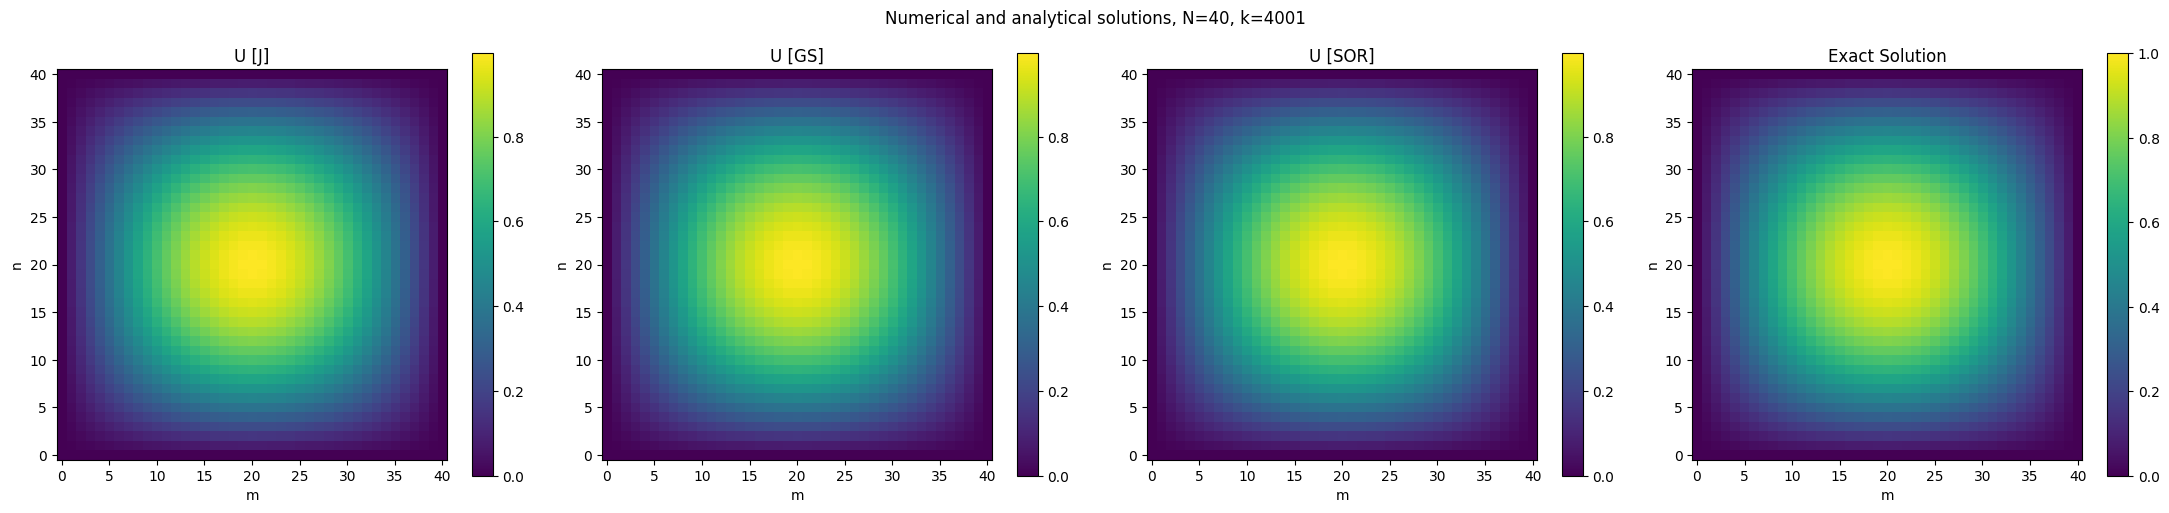

In [13]:
plot_results(N, max_k, U_jacobi, U_gs, U_sor)

### Chute inicial $\text{constante} \ne 0$

Pelos experimentos abaixo, é possível observar que os métodos convergem para alguns chutes iniciais constantes.

Também podemos notar que os métodos levam mais tempo para convergir para condições iniciais mais distantes da solução exata, como esperado.


In [14]:
errors_jacobi = []
errors_gs = []
errors_sor = []
ks = []

max_ks = [2, 3, 4, 11, 401, 1001, 4001]
N = 40

# Initial guess constant equal to 1
initial_guess = np.ones((N + 1) ** 2)

for max_k in max_ks:
    U_jacobi, error_jacobi, k_jacobi, U_gs, error_gs, k_gs, U_sor, error_sor, k_sor = (
        run_convergence_initial_guess(initial_guess, N=N, max_k=max_k)
    )
    errors_jacobi.append(error_jacobi)
    errors_gs.append(error_gs)
    errors_sor.append(error_sor)
    ks.append(k_jacobi)

df = create_table(
    [
        ks,
        errors_jacobi,
        errors_gs,
        errors_sor,
    ],
    [
        "k",
        "E [J]",
        "E [GS]",
        "E [SOR]",
    ],
)
df = create_ratio_column(df, "E ratio [J]", "E [J]")
df = create_ratio_column(df, "E ratio [GS]", "E [GS]")
df = create_ratio_column(df, "E ratio [SOR]", "E [SOR]")
print(df)

h = 1 / N
lam_gs = (lam_jacobi(1 / N, 1, 1)) ** 2
print(
    f"h: {h}\nlam [J]: {float(lam_jacobi(1 / N, 1, 1)):.6f}\nlam [GS]: {float(lam_gs):.6f}"
)

        k     E [J]    E [GS]   E [SOR] E ratio [J] E ratio [GS] E ratio [SOR]
0     1.0  3.620450  3.436996  3.232319                                       
1     2.0  3.516224  3.289060  3.046840    0.971212     0.956958      0.942617
2     3.0  3.427966  3.166784  2.897516      0.9749     0.962823       0.95099
3    10.0  3.005499  2.610692  2.251297    0.876759     0.824399      0.776975
4   400.0  0.569165  0.167263  0.032587    0.189374     0.064068      0.014475
5  1000.0  0.090642  0.009971  0.009934    0.159254     0.059613      0.304842
6  1766.0  0.009989  0.009971  0.009934    0.110206          1.0           1.0
h: 0.025
lam [J]: 0.996917
lam [GS]: 0.993844


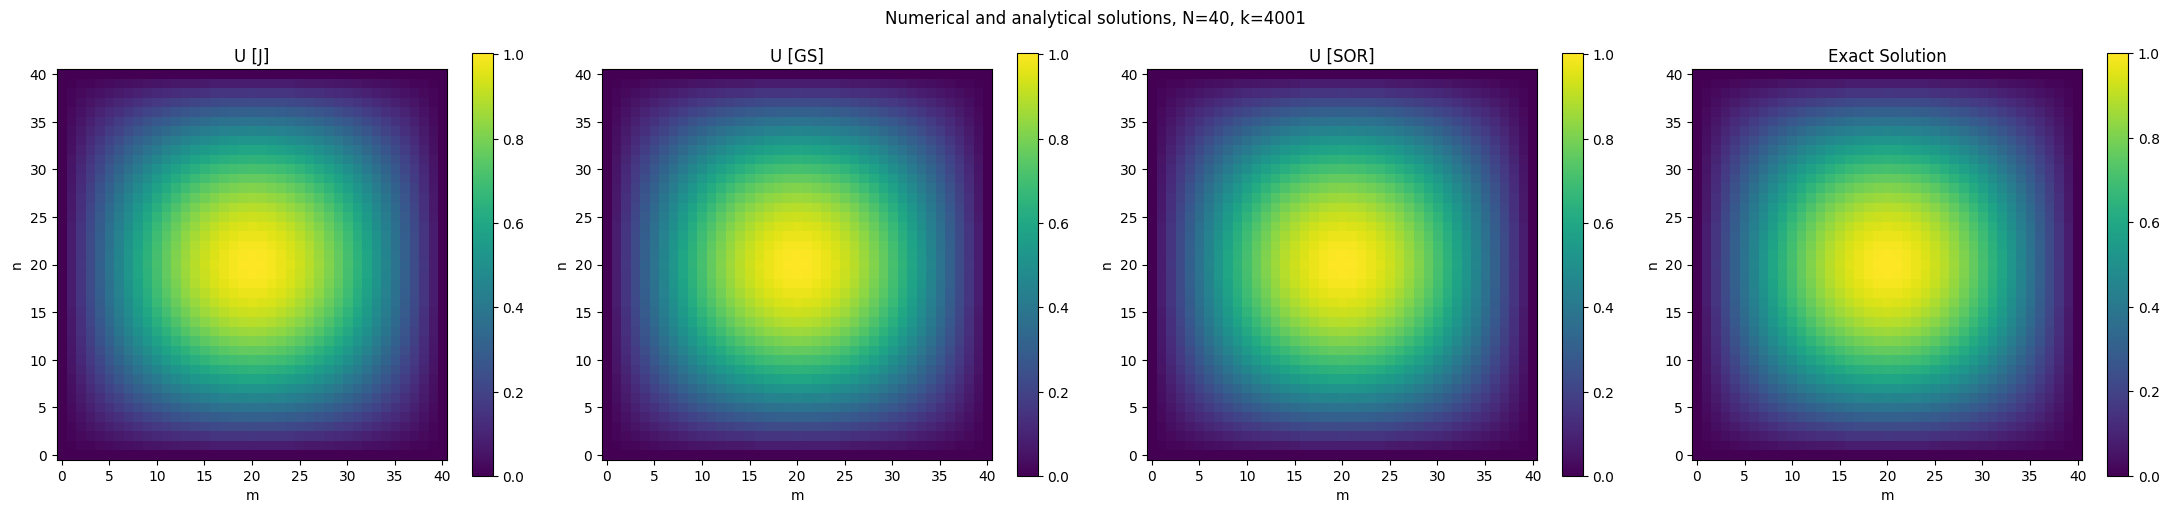

In [15]:
plot_results(N, max_k, U_jacobi, U_gs, U_sor)

In [16]:
errors_jacobi = []
errors_gs = []
errors_sor = []
ks = []

max_ks = [2, 3, 4, 11, 401, 1001, 4001]
N = 40

# Initial guess constant equal to 100
initial_guess = np.ones((N + 1) ** 2) * 100

for max_k in max_ks:
    U_jacobi, error_jacobi, k_jacobi, U_gs, error_gs, k_gs, U_sor, error_sor, k_sor = (
        run_convergence_initial_guess(initial_guess, N=N, max_k=max_k)
    )
    errors_jacobi.append(error_jacobi)
    errors_gs.append(error_gs)
    errors_sor.append(error_sor)
    ks.append(k_jacobi)

df = create_table(
    [
        ks,
        errors_jacobi,
        errors_gs,
        errors_sor,
    ],
    [
        "k",
        "E [J]",
        "E [GS]",
        "E [SOR]",
    ],
)
df = create_ratio_column(df, "E ratio [J]", "E [J]")
df = create_ratio_column(df, "E ratio [GS]", "E [GS]")
df = create_ratio_column(df, "E ratio [SOR]", "E [SOR]")
print(df)

h = 1 / N
lam_gs = (lam_jacobi(1 / N, 1, 1)) ** 2
print(
    f"h: {h}\nlam [J]: {float(lam_jacobi(1 / N, 1, 1)):.6f}\nlam [GS]: {float(lam_gs):.6f}"
)

        k       E [J]      E [GS]     E [SOR] E ratio [J] E ratio [GS]  \
0     1.0  590.790447  577.231148  562.078422                            
1     2.0  583.312254  566.193277  547.655267    0.987342     0.980878   
2     3.0  576.880217  556.827745  535.540471    0.988973     0.983459   
3    10.0  544.521008  510.438828  475.594894    0.943907     0.916691   
4   400.0  147.573159   42.975743    8.032439    0.271015     0.084194   
5  1000.0   23.148301    1.059185    0.017681     0.15686     0.024646   
6  3567.0    0.009992    0.009978    0.009986    0.000432     0.009421   

  E ratio [SOR]  
0                
1       0.97434  
2      0.977879  
3      0.888065  
4      0.016889  
5      0.002201  
6      0.564765  
h: 0.025
lam [J]: 0.996917
lam [GS]: 0.993844


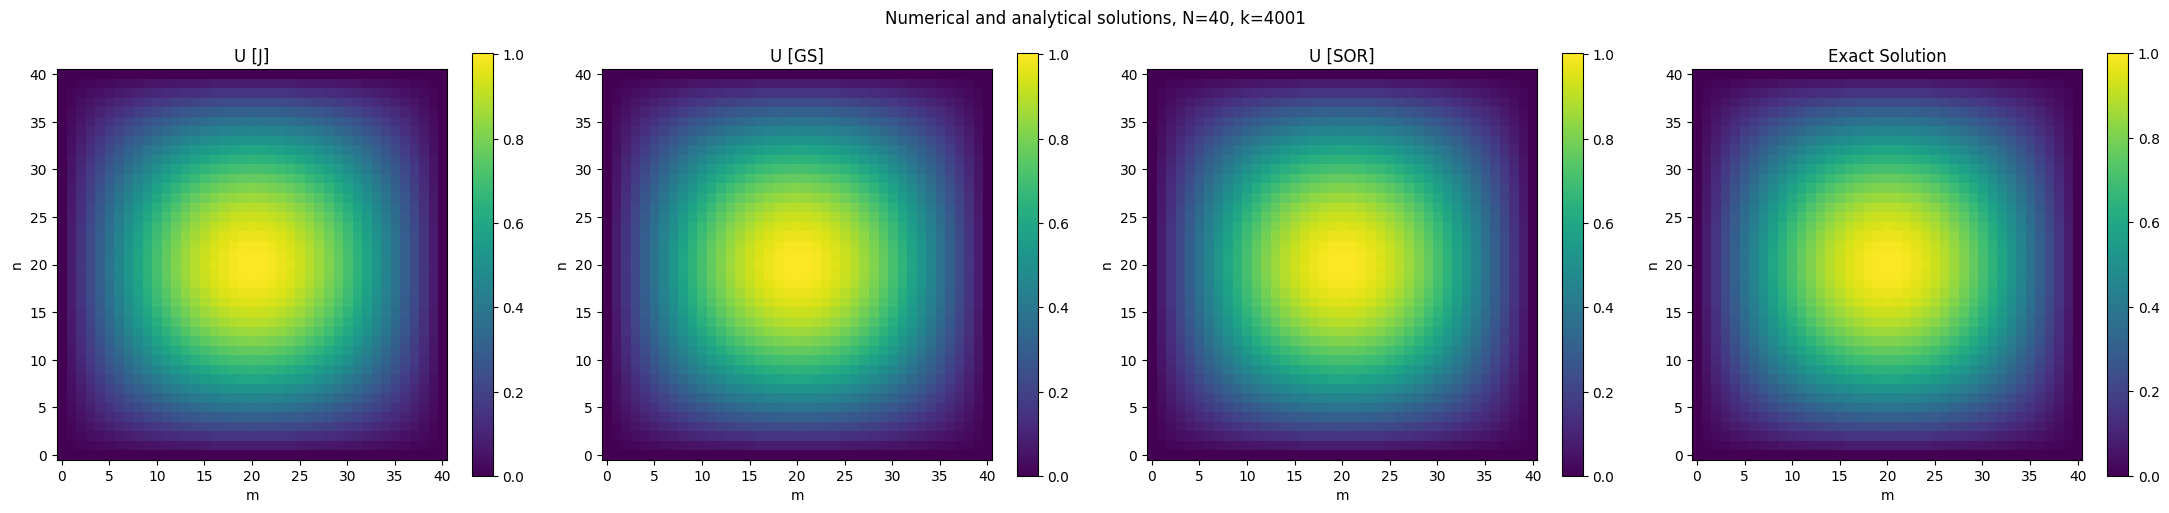

In [17]:
plot_results(N, max_k, U_jacobi, U_gs, U_sor)

### Chute inicial aleatório

No experimento abaixo, os métodos convergem para uma condição inicial aleatória de amplitude igual a 10.


In [18]:
errors_jacobi = []
errors_gs = []
errors_sor = []
ks = []

max_ks = [2, 3, 4, 11, 401, 1001, 4001]
N = 40

# Initial guess constant equal to 100
np.random.seed(1)
initial_guess = np.random.random(size=(N + 1) ** 2) * 10

for max_k in max_ks:
    U_jacobi, error_jacobi, k_jacobi, U_gs, error_gs, k_gs, U_sor, error_sor, k_sor = (
        run_convergence_initial_guess(initial_guess, N=N, max_k=max_k)
    )
    errors_jacobi.append(error_jacobi)
    errors_gs.append(error_gs)
    errors_sor.append(error_sor)
    ks.append(k_jacobi)

df = create_table(
    [
        ks,
        errors_jacobi,
        errors_gs,
        errors_sor,
    ],
    [
        "k",
        "E [J]",
        "E [GS]",
        "E [SOR]",
    ],
)
df = create_ratio_column(df, "E ratio [J]", "E [J]")
df = create_ratio_column(df, "E ratio [GS]", "E [GS]")
df = create_ratio_column(df, "E ratio [SOR]", "E [SOR]")
print(df)

h = 1 / N
lam_gs = (lam_jacobi(1 / N, 1, 1)) ** 2
print(
    f"h: {h}\nlam [J]: {float(lam_jacobi(1 / N, 1, 1)):.6f}\nlam [GS]: {float(lam_gs):.6f}"
)

        k      E [J]     E [GS]    E [SOR] E ratio [J] E ratio [GS]  \
0     1.0  28.048200  26.859573  28.736951                            
1     2.0  27.413816  26.115845  28.127718    0.977382     0.972311   
2     3.0  26.939153  25.547138  27.987892    0.982685     0.978224   
3    10.0  24.916424  22.994124  42.417767    0.924915     0.900067   
4   400.0   6.477854   1.888220   0.354197    0.259983     0.082118   
5  1000.0   1.017391   0.048055   0.009920    0.157057      0.02545   
6  2555.0   0.009978   0.009968   0.009920    0.009807     0.207421   

  E ratio [SOR]  
0                
1        0.9788  
2      0.995029  
3      1.515576  
4       0.00835  
5      0.028006  
6           1.0  
h: 0.025
lam [J]: 0.996917
lam [GS]: 0.993844


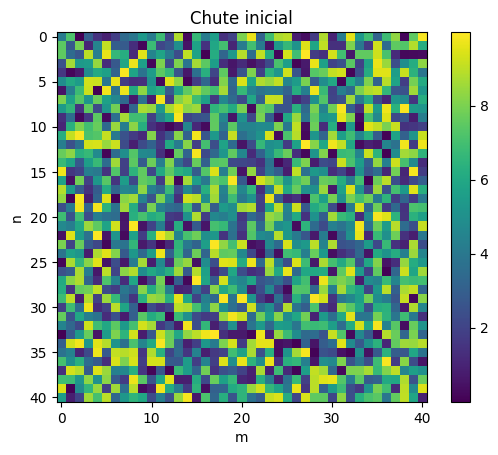

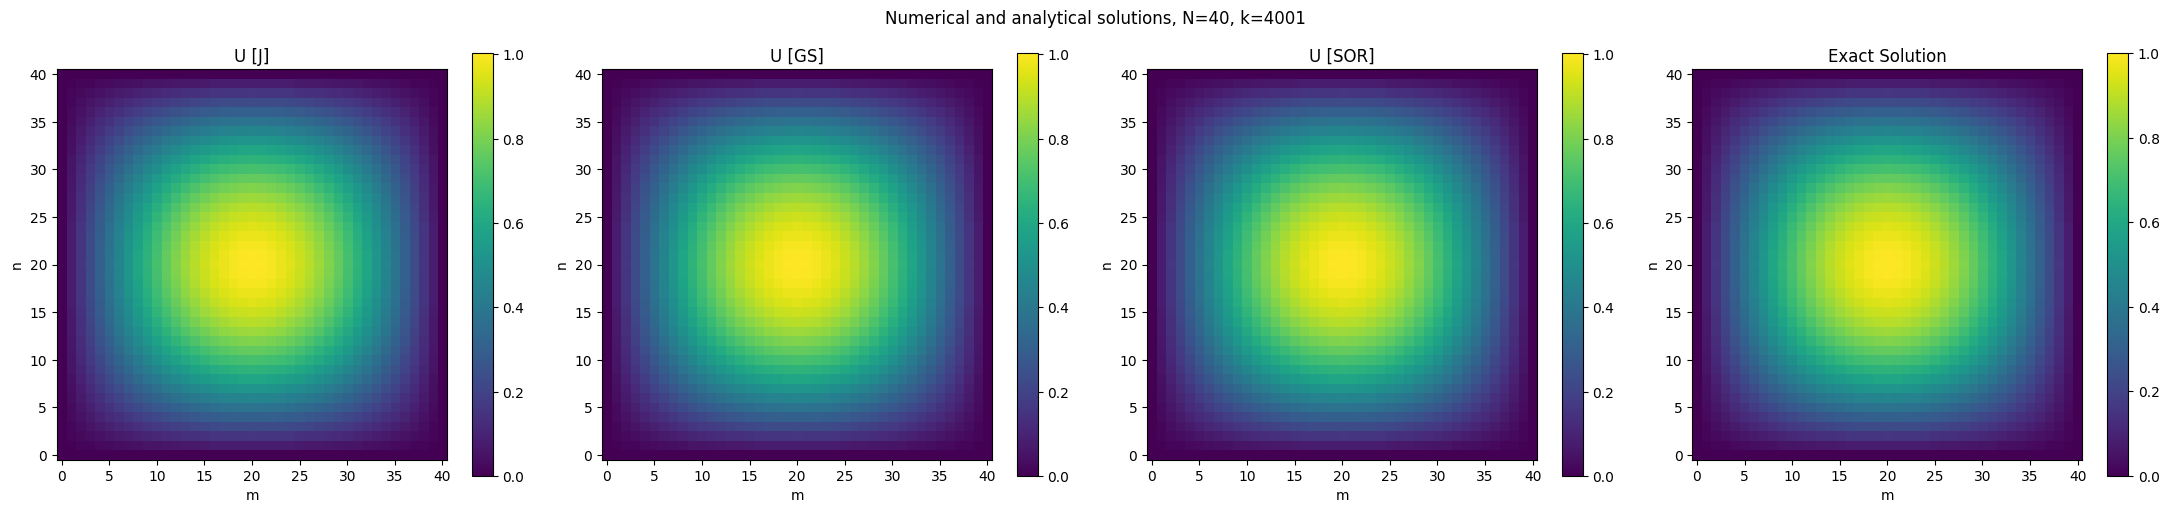

In [19]:
plt.imshow(initial_guess.reshape((N + 1, N + 1)))
plt.title("Chute inicial")
plt.ylabel("n")
plt.xlabel("m")
plt.colorbar()
plot_results(N, max_k, U_jacobi, U_gs, U_sor)